Пробуем сделать простое дерево решений и работать с ним

In [1]:
from IPython.display import display_markdown

# Задача 1. Сколько заплатить за месторождение?

Вы покупаете месторождение нефти. Известна геологическая оценка извлекаемых запасов:

- p10 - 1 млн тонн нефти
- p50 - 1.1 млн тонн нефти
- p90 - 1.2 млн тонн нефти

Стоимость 1 тонны нефти в запасах – 1 тыс. руб.

Готовы ли купить месторождение за 1.1 млрд.руб? Сколько вы готовы заплатить?

Для решения задачи можно построить дерево решений с использованием [silverdecisions.pl](https://silverdecisions.pl/)

Получится что как на рисунке ниже

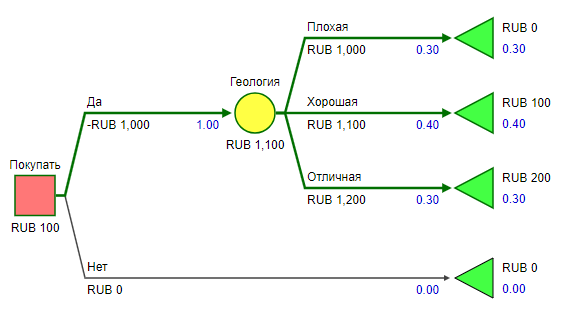

Дерево состоит из одного узла принятия решений (Покупать), одного вероятностного узла (Геология) и трех вариантов исходов для вероятностного узла (Плохая, Хорошая, Отличная). Затраты и выигрыше в дереве приведены в млн.руб. Анализ дерева показывает, что ожидаемая доходной вероятностного узла "Геология" составляет $EMV_{геология}= 1100$ млн.руб.

При построении дерева перцентили p10, p50, p 90 были заменены на вероятности 0.3, 0.4, 0.5 согласно расширенному методу Свенсона Мегилла (Extended Swanson-Megill Method).  (надо добавить ссылку и расширить описание - возможно в виде отдельного ноутбука).

Альтернатива покупке месторождения не приносит ни проигрышей ни выигрышей $EMV_{не_покупать}= 1100$ млн.руб.

Таким образом при стоимости месторождении 1 млрд. руб. общая доходность решения покупать $EMV_{покупать}= 100$ млн.руб.  $EMV_{покупать} > EMV_{не_покупать}$ поэтому покупка целесообразна (при условии максимизации доходности как критерия принятия решений).

Для удобства дальшейнего анализа автоматизируем расчет с использованием скриптов python. Для этого зададим дерево в виде словаря и приведем функции расчета дерева и его анализа.

In [2]:
tree = {"name": "Покупать",
        "type": "decision",
        "child_edges":[
                       {"name": "Да",
                        "payoff": -1000,
                        "child_node": 
                                    {"name": "Геология",
                                     "type": "chance",
                                     "child_edges": [
                                                    {"name": "Плохая",
                                                     "payoff": 1000,
                                                     "probability": 0.3,
                                                     "child_node": {"type": "terminal"}
                                                    },
                                                    {"name": "Хорошая",
                                                     "payoff": 1100,
                                                     "probability": 0.4,
                                                     "child_node": {"type": "terminal"}
                                                    },
                                                    {"name": "Отличная",
                                                     "payoff": 1200,
                                                     "probability": 0.3,
                                                     "child_node": {"type": "terminal"}
                                                    },
                                                    ]  
                                    }
                        },
                        {"name": "Нет",
                         "payoff": 0,
                         "child_node": {"type": "terminal"}
                        }
                    ]  
        }

Для удобства анализа приведем функции транслирующую дерево в виде словаря python (заданного на основе формата json) в текстовый формат [mermaid]((https://mermaid.js.org/)) пригодный для построения диаграмм. 

In [3]:
def tree_to_mermaid_chart(tree):
    """
    преобразует дерево в строку пригодную для отображения диаграмм mermaid (https://mermaid.js.org/)
    """
    def get_node_list(tree, nodes=[], i=0):
        """
        рекурсивно вытаскиваем и нумеруем все узлы для отображения
        """
        if tree['type'] == 'terminal':
            snode =  ( "  p = " + str(tree['p']) if 'p' in tree else "")
            snode = snode + ( " <br> v = " + str(tree['v']) if 'v' in tree else "")
            snode = "." if snode=="" else snode
            nodes.append(str(i) +"{"+snode+"}")
            nodes.append("style "+str(i)+"  fill:#00C853")
        if tree['type'] == 'decision':
            snode = tree['name']
            snode = snode + ( " <br> payoff = " + f"{tree['payoff']:.2f}" if 'payoff' in tree else "")
            snode = snode + ( " <br> emv = " + f"{tree['emv']:.2f}" if 'emv' in tree else "")
            snode = snode + ( " <br> voi = " + f"{tree['voi']:.2f}" if 'voi' in tree else "")
            nodes.append(str(i) + "[" +snode+"]")
            nodes.append("style "+str(i)+"  fill:#FF6D00")
        if tree['type'] == 'chance':
            snode = tree['name']
            snode = snode + ( " <br> payoff = " + f"{tree['payoff']:.2f}" if 'payoff' in tree else "")
            snode = snode + ( " <br> p = " + f"{tree['probability']:.2f}" if 'probability' in tree else "")
            snode = snode + ( " <br> emv = " + f"{tree['emv']:.2f}" if 'emv' in tree else "")
            nodes.append(str(i) + "(("+snode+"))")
            nodes.append("style "+str(i)+"  fill:#FFD600")
        tree['_id_'] = i
        i = i + 1
        if 'child_edges' in tree:
            for edge in tree['child_edges']:
                i = get_node_list(edge['child_node'], nodes, i)
        return i

    def get_edge_list(tree, nodes=[]):
        """
        рекурсивно строим связи для всех узлов
        """
        if tree['type'] != 'terminal':
            if 'child_edges' in tree:
                for edge in tree['child_edges']:
                    sedge = edge['name']
                    sedge = sedge + ( " <br> payoff = " + str(edge['payoff']) if 'payoff' in edge else "")
                    sedge = sedge + ( " <br> p = " + str(edge['probability']) if 'probability' in edge else "")
                    
                    nodes.append(str(tree['_id_']) +"--" + sedge +"-->" + str(edge['child_node']['_id_'] ))
                    get_edge_list(edge['child_node'], nodes)
                    
    nodes = ["```mermaid", " flowchart LR"]
    tr = tree.copy()            
    get_node_list(tr, nodes)
    get_edge_list(tr, nodes)
    st=""
    for s in nodes:
        st = st + s + " \n"
    return st

In [4]:
"""
вывод дерева в текстовом формате mermaid
"""
print(tree_to_mermaid_chart(tree))

```mermaid 
 flowchart LR 
0[Покупать] 
style 0  fill:#FF6D00 
1((Геология)) 
style 1  fill:#FFD600 
2{.} 
style 2  fill:#00C853 
3{.} 
style 3  fill:#00C853 
4{.} 
style 4  fill:#00C853 
5{.} 
style 5  fill:#00C853 
0--Да <br> payoff = -1000-->1 
1--Плохая <br> payoff = 1000 <br> p = 0.3-->2 
1--Хорошая <br> payoff = 1100 <br> p = 0.4-->3 
1--Отличная <br> payoff = 1200 <br> p = 0.3-->4 
0--Нет <br> payoff = 0-->5 



In [5]:
"""
отображения дерева в формате mermaid 
работает в jupyter notebook, может не работать в colab или при просмотре на github
"""
display_markdown(tree_to_mermaid_chart(tree), raw=True)

```mermaid 
 flowchart LR 
0[Покупать] 
style 0  fill:#FF6D00 
1((Геология)) 
style 1  fill:#FFD600 
2{.} 
style 2  fill:#00C853 
3{.} 
style 3  fill:#00C853 
4{.} 
style 4  fill:#00C853 
5{.} 
style 5  fill:#00C853 
0--Да <br> payoff = -1000-->1 
1--Плохая <br> payoff = 1000 <br> p = 0.3-->2 
1--Хорошая <br> payoff = 1100 <br> p = 0.4-->3 
1--Отличная <br> payoff = 1200 <br> p = 0.3-->4 
0--Нет <br> payoff = 0-->5 


In [6]:
def solve_tree(tree, v=0, p=0):
    """
    рекурсивное решение дерева заданного в виде словаря
    """
    
    if tree['type'] == 'terminal':
        # для терминального узла сохраняем в нем итоговые выигрыши и вероятности
        tree['emv'] = 0
        tree['v'] = v
        tree['p'] = p
    else:
        # или 'decision' или 'chance' с дочерними узлами
        tree['emv'] = 0
        if tree['type'] == 'decision':
            tree['emvs'] = {}
            num = 0
        
        for edge in tree['child_edges']:
            # переберем все связи рассматриваемого узла
            if tree['type'] == 'decision':
                edge['id'] = num
                num = num + 1

            # рекурсивно рассчитаем параметры дочерних узлов
            solve_tree(edge['child_node'], edge['payoff']+v, edge['probability'] if 'probability' in edge else 0 * p)

            # рассчитаем emv рассматриваемого узла
            if tree['type'] == 'decision':
                tree['emvs'][edge['id']] = edge['child_node']['emv'] + edge['payoff']
            else:
                tree['emv'] = tree['emv'] + (edge['child_node']['emv'] + edge['payoff']) * edge['probability']

        # для узла решения определим оптимальное - из максимизации EMV
        if tree['type'] == 'decision':
            tree['emv'] = max(tree['emvs'].values())
            for edge in tree['child_edges']:
                if tree['emvs'][edge['id']] == tree['emv']:
                    edge['probability'] = 1
                else:
                    edge['probability'] = 0
            # оценим VOI для узла решения
            emv_wi = 0
            emv_woi = 0
            calc_voi = [False, False]
            for edge in tree['child_edges']:
                if 'voi_info' in edge:
                    if edge['voi_info']=='with_info':
                        emv_wi = tree['emvs'][edge['id']] - edge['payoff']
                        calc_voi[0] = True
                    if edge['voi_info']=='without_info':
                        emv_woi = tree['emvs'][edge['id']] - edge['payoff']
                        calc_voi[1] = True
            if calc_voi == [True, True]:
                tree['voi'] = emv_wi - emv_woi
      



def print_tree(tree, level=0):
    if level == 0:
        print('|','-'*level,  f" {tree['type']} : {tree['name'] if 'name' in tree else ''} [ {tree['emv']}]" )
    else:
        if 'child_node' in tree:
            print('|', '-'*level,  
                  f" {tree['name']} ",
                  f" [payoff:{tree['payoff']} { (' p = ' + str(tree['probability'])) if 'probability' in tree else '' }] -> ",
                  f"  {tree['child_node']['type']} : {tree['child_node']['name'] if 'name' in tree['child_node'] else ''} [ emv = {tree['child_node']['emv']}]",
                  f" ({tree['child_node']['p']} {tree['child_node']['v']})" if tree['child_node']['type']=='terminal' else '' )


    if 'child_edges' in tree:
        for edge in tree['child_edges']:
            print_tree(edge, level=level+2)
            print_tree(edge['child_node'], level=level+2)

solve_tree(tree)
print('===========================')
print_tree(tree)

|   decision : Покупать [ 100.0]
| --  Да   [payoff:-1000  p = 1] ->    chance : Геология [ emv = 1100.0] 
| ----  Плохая   [payoff:1000  p = 0.3] ->    terminal :  [ emv = 0]  (0.3 0)
| ----  Хорошая   [payoff:1100  p = 0.4] ->    terminal :  [ emv = 0]  (0.4 100)
| ----  Отличная   [payoff:1200  p = 0.3] ->    terminal :  [ emv = 0]  (0.3 200)
| --  Нет   [payoff:0  p = 0] ->    terminal :  [ emv = 0]  (0 0)


In [7]:
display_markdown(tree_to_mermaid_chart(tree), raw=True)

```mermaid 
 flowchart LR 
0[Покупать <br> emv = 100.00] 
style 0  fill:#FF6D00 
1((Геология <br> emv = 1100.00)) 
style 1  fill:#FFD600 
2{  p = 0.3 <br> v = 0} 
style 2  fill:#00C853 
3{  p = 0.4 <br> v = 100} 
style 3  fill:#00C853 
4{  p = 0.3 <br> v = 200} 
style 4  fill:#00C853 
5{  p = 0 <br> v = 0} 
style 5  fill:#00C853 
0--Да <br> payoff = -1000 <br> p = 1-->1 
1--Плохая <br> payoff = 1000 <br> p = 0.3-->2 
1--Хорошая <br> payoff = 1100 <br> p = 0.4-->3 
1--Отличная <br> payoff = 1200 <br> p = 0.3-->4 
0--Нет <br> payoff = 0 <br> p = 0-->5 


Видно, что функции решения дерева дают результаты аналогичные дереву построенному в программе [silverdecisions.pl](https://silverdecisions.pl/)

# задача 1.2

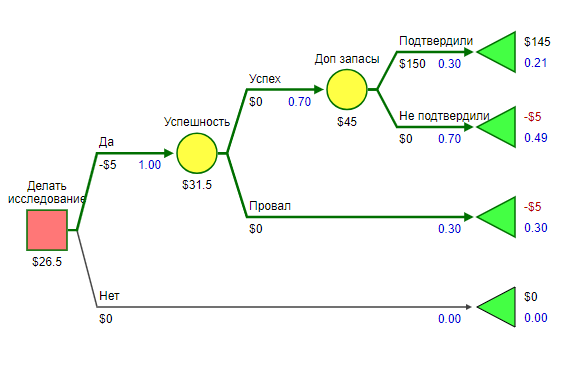

In [8]:
tree2 = {"name": "Исследовать",
        "type": "decision",
        "child_edges":[
                       {"name": "Да",
                        "voi_info":"with_info",
                        "payoff": -5,
                        "child_node": 
                                    {"name": "Успешность",
                                     "type": "chance",
                                     "child_edges": [
                                                    {"name": "Успех",
                                                     "payoff": 0,
                                                     "probability": 0.7,
                                                     "child_node":
                                                                    {"name": "Запасы",
                                                                     "type": "chance",
                                                                     "child_edges": [
                                                                                    {"name": "Подтвердили",
                                                                                     "payoff": 150,
                                                                                     "probability": 0.3,
                                                                                     "child_node": {"type": "terminal"}
                                                                                    },
                                                                                    {"name": "Не подтвердили",
                                                                                     "payoff": 0,
                                                                                     "probability": 0.7,
                                                                                     "child_node": {"type": "terminal"}
                                                                                    },
                                                                                    ]  
                                                                    }
                                                    },
                                                    {"name": "Провал",
                                                     "payoff": 0,
                                                     "probability": 0.3,
                                                     "child_node": {"type": "terminal"}
                                                    },
                                                    ]  
                                    }
                        },
                        {"name": "Нет",
                         "voi_info":"without_info",
                         "payoff": 0,
                         "child_node": {"type": "terminal"}
                        }
                    ]  
        }

In [9]:
display_markdown(tree_to_mermaid_chart(tree2), raw=True)

```mermaid 
 flowchart LR 
0[Исследовать] 
style 0  fill:#FF6D00 
1((Успешность)) 
style 1  fill:#FFD600 
2((Запасы)) 
style 2  fill:#FFD600 
3{.} 
style 3  fill:#00C853 
4{.} 
style 4  fill:#00C853 
5{.} 
style 5  fill:#00C853 
6{.} 
style 6  fill:#00C853 
0--Да <br> payoff = -5-->1 
1--Успех <br> payoff = 0 <br> p = 0.7-->2 
2--Подтвердили <br> payoff = 150 <br> p = 0.3-->3 
2--Не подтвердили <br> payoff = 0 <br> p = 0.7-->4 
1--Провал <br> payoff = 0 <br> p = 0.3-->5 
0--Нет <br> payoff = 0-->6 


In [10]:
solve_tree(tree2)
display_markdown(tree_to_mermaid_chart(tree2), raw=True)

```mermaid 
 flowchart LR 
0[Исследовать <br> emv = 26.50 <br> voi = 31.50] 
style 0  fill:#FF6D00 
1((Успешность <br> emv = 31.50)) 
style 1  fill:#FFD600 
2((Запасы <br> emv = 45.00)) 
style 2  fill:#FFD600 
3{  p = 0.3 <br> v = 145} 
style 3  fill:#00C853 
4{  p = 0.7 <br> v = -5} 
style 4  fill:#00C853 
5{  p = 0.3 <br> v = -5} 
style 5  fill:#00C853 
6{  p = 0 <br> v = 0} 
style 6  fill:#00C853 
0--Да <br> payoff = -5 <br> p = 1-->1 
1--Успех <br> payoff = 0 <br> p = 0.7-->2 
2--Подтвердили <br> payoff = 150 <br> p = 0.3-->3 
2--Не подтвердили <br> payoff = 0 <br> p = 0.7-->4 
1--Провал <br> payoff = 0 <br> p = 0.3-->5 
0--Нет <br> payoff = 0 <br> p = 0-->6 


# Задача 2

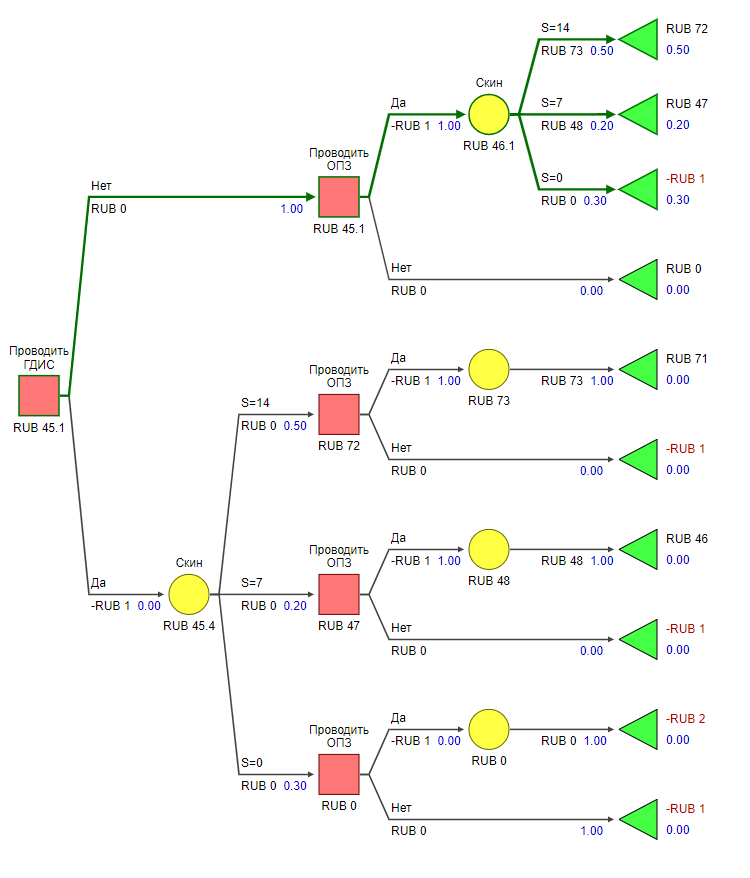

In [11]:
tree3 = {"name": "ГДИС",
        "type": "decision",
        "child_edges":[
                       {"name": "Да",
                        "voi_info":"with_info",
                        "payoff": -1,
                        "child_node": 
                                    {"name": "Скин",
                                     "type": "chance",
                                     "child_edges": [
                                                    {"name": "S=14",
                                                     "payoff": 0,
                                                     "probability": 0.5,
                                                     "child_node": 
                                                                {"name": "ОПЗ",
                                                                 "type": "decision",
                                                                 "child_edges":[
                                                                                   {"name": "Да",
                                                                                    "voi_info":"with_info",
                                                                                    "payoff": 72,
                                                                                    "child_node": {"type": "terminal"}                                                                                               
                                                                                    },
                                                                                    {"name": "Нет",
                                                                                     "voi_info":"without_info",
                                                                                     "payoff": 0,
                                                                                     "child_node": {"type": "terminal"}
                                                                                    }
                                                                                ]  
                                                                }
                                                    },
                                                    {"name": "S=7",
                                                     "payoff": 0,
                                                     "probability": 0.2,
                                                     "child_node": 
                                                                {"name": "ОПЗ",
                                                                 "type": "decision",
                                                                 "child_edges":[
                                                                                   {"name": "Да",
                                                                                    "voi_info":"with_info",
                                                                                    "payoff": 47,
                                                                                    "child_node": {"type": "terminal"}                                                                                               
                                                                                    },
                                                                                    {"name": "Нет",
                                                                                     "voi_info":"without_info",
                                                                                     "payoff": 0,
                                                                                     "child_node": {"type": "terminal"}
                                                                                    }
                                                                                ]  
                                                                }
                                                    },
                                                    {"name": "S=0",
                                                     "payoff": 0,
                                                     "probability": 0.3,
                                                     "child_node": 
                                                                {"name": "ОПЗ",
                                                                 "type": "decision",
                                                                 "child_edges":[
                                                                                   {"name": "Да",
                                                                                    "voi_info":"with_info",
                                                                                    "payoff": -1,
                                                                                    "child_node": {"type": "terminal"}                                                                                               
                                                                                    },
                                                                                    {"name": "Нет",
                                                                                     "voi_info":"without_info",
                                                                                     "payoff": 0,
                                                                                     "child_node": {"type": "terminal"}
                                                                                    }
                                                                                ]  
                                                                }
                                                    },
                                                    ]  
                                    }
                        },
                        {"name": "Нет",
                         "voi_info":"without_info",
                         "payoff": 0,
                         "child_node": 
                             {"name": "ОПЗ",
                             "type": "decision",
                             "child_edges":[
                                               {"name": "Да",
                                                "voi_info":"with_info",
                                                "payoff": -1,
                                                "child_node": 
                                                    {"name": "Скин",
                                                         "type": "chance",
                                                         "child_edges": [
                                                                        {"name": "S=14",
                                                                         "payoff": 73,
                                                                         "probability": 0.5,
                                                                         "child_node": {"type": "terminal"}  
                                                                                    
                                                                        },
                                                                        {"name": "S=7",
                                                                         "payoff": 48,
                                                                         "probability": 0.2,
                                                                         "child_node": {"type": "terminal"}  
                                                                                   
                                                                        },
                                                                        {"name": "S=0",
                                                                         "payoff": 0,
                                                                         "probability": 0.3,
                                                                         "child_node": {"type": "terminal"}  
                                                                                   
                                                                        },
                                                                        ]  
                                                        }                                                                                       
                                                },
                                                {"name": "Нет",
                                                 "voi_info":"without_info",
                                                 "payoff": 0,
                                                 "child_node": {"type": "terminal"}
                                                }
                                            ]  
                            }
                        }
                    ]  
        }

In [12]:
display_markdown(tree_to_mermaid_chart(tree3), raw=True)

```mermaid 
 flowchart LR 
0[ГДИС] 
style 0  fill:#FF6D00 
1((Скин)) 
style 1  fill:#FFD600 
2[ОПЗ] 
style 2  fill:#FF6D00 
3{.} 
style 3  fill:#00C853 
4{.} 
style 4  fill:#00C853 
5[ОПЗ] 
style 5  fill:#FF6D00 
6{.} 
style 6  fill:#00C853 
7{.} 
style 7  fill:#00C853 
8[ОПЗ] 
style 8  fill:#FF6D00 
9{.} 
style 9  fill:#00C853 
10{.} 
style 10  fill:#00C853 
11[ОПЗ] 
style 11  fill:#FF6D00 
12((Скин)) 
style 12  fill:#FFD600 
13{.} 
style 13  fill:#00C853 
14{.} 
style 14  fill:#00C853 
15{.} 
style 15  fill:#00C853 
16{.} 
style 16  fill:#00C853 
0--Да <br> payoff = -1-->1 
1--S=14 <br> payoff = 0 <br> p = 0.5-->2 
2--Да <br> payoff = 72-->3 
2--Нет <br> payoff = 0-->4 
1--S=7 <br> payoff = 0 <br> p = 0.2-->5 
5--Да <br> payoff = 47-->6 
5--Нет <br> payoff = 0-->7 
1--S=0 <br> payoff = 0 <br> p = 0.3-->8 
8--Да <br> payoff = -1-->9 
8--Нет <br> payoff = 0-->10 
0--Нет <br> payoff = 0-->11 
11--Да <br> payoff = -1-->12 
12--S=14 <br> payoff = 73 <br> p = 0.5-->13 
12--S=7 <br> payoff = 48 <br> p = 0.2-->14 
12--S=0 <br> payoff = 0 <br> p = 0.3-->15 
11--Нет <br> payoff = 0-->16 


In [13]:
solve_tree(tree3)
display_markdown(tree_to_mermaid_chart(tree3), raw=True)

```mermaid 
 flowchart LR 
0[ГДИС <br> emv = 45.10 <br> voi = 0.30] 
style 0  fill:#FF6D00 
1((Скин <br> emv = 45.40)) 
style 1  fill:#FFD600 
2[ОПЗ <br> emv = 72.00 <br> voi = 0.00] 
style 2  fill:#FF6D00 
3{  p = 0.0 <br> v = 71} 
style 3  fill:#00C853 
4{  p = 0.0 <br> v = -1} 
style 4  fill:#00C853 
5[ОПЗ <br> emv = 47.00 <br> voi = 0.00] 
style 5  fill:#FF6D00 
6{  p = 0.0 <br> v = 46} 
style 6  fill:#00C853 
7{  p = 0.0 <br> v = -1} 
style 7  fill:#00C853 
8[ОПЗ <br> emv = 0.00 <br> voi = 0.00] 
style 8  fill:#FF6D00 
9{  p = 0.0 <br> v = -2} 
style 9  fill:#00C853 
10{  p = 0.0 <br> v = -1} 
style 10  fill:#00C853 
11[ОПЗ <br> emv = 45.10 <br> voi = 46.10] 
style 11  fill:#FF6D00 
12((Скин <br> emv = 46.10)) 
style 12  fill:#FFD600 
13{  p = 0.5 <br> v = 72} 
style 13  fill:#00C853 
14{  p = 0.2 <br> v = 47} 
style 14  fill:#00C853 
15{  p = 0.3 <br> v = -1} 
style 15  fill:#00C853 
16{  p = 0 <br> v = 0} 
style 16  fill:#00C853 
0--Да <br> payoff = -1 <br> p = 0-->1 
1--S=14 <br> payoff = 0 <br> p = 0.5-->2 
2--Да <br> payoff = 72 <br> p = 1-->3 
2--Нет <br> payoff = 0 <br> p = 0-->4 
1--S=7 <br> payoff = 0 <br> p = 0.2-->5 
5--Да <br> payoff = 47 <br> p = 1-->6 
5--Нет <br> payoff = 0 <br> p = 0-->7 
1--S=0 <br> payoff = 0 <br> p = 0.3-->8 
8--Да <br> payoff = -1 <br> p = 0-->9 
8--Нет <br> payoff = 0 <br> p = 1-->10 
0--Нет <br> payoff = 0 <br> p = 1-->11 
11--Да <br> payoff = -1 <br> p = 1-->12 
12--S=14 <br> payoff = 73 <br> p = 0.5-->13 
12--S=7 <br> payoff = 48 <br> p = 0.2-->14 
12--S=0 <br> payoff = 0 <br> p = 0.3-->15 
11--Нет <br> payoff = 0 <br> p = 0-->16 


Надо подставить вместо цифр расчетные формулы 
и нарисовать графики 
- зависимости EMV, VOI от стоимости ОПЗ
- зависимости EMV, VOI от стоимости ГДИС
- зависимости EMV, VOI от вероятности наличия скин-фактора (средний скин и дисперсия)

# Задача 3

In [14]:
tree2 = {"name": "Покупать",
        "type": "decision",
        "child_edges":[
                        {"name": "Да",
                         "payoff": -100,
                         "child_node": 
                                {"name": "Успех",
                                 "type": "chance",
                                 "child_edges": [
                                                    {"name": "Да",
                                                    "payoff": 100,
                                                    "probability": 0.6,
                                                    "child_node": 
                                                                    {"name": "Результат",
                                                                     "type": "chance",
                                                                     "child_edges": [
                                                                                        {"name": "Да",
                                                                                        "payoff": 1000,
                                                                                        "probability": 0.8,
                                                                                        "child_node": {"type": "terminal"}
                                                                                        },
                                                                                        {"name": "Нет",
                                                                                        "payoff": -10,
                                                                                        "probability": 0.2,
                                                                                        "child_node": {"type": "terminal"}
                                                                                        },
                                                                                    ]  
                                                                    }
                                                                
                                                     
                                                    },
                                                    {"name": "Нет",
                                                    "payoff": -10,
                                                    "probability": 0.4,
                                                    "child_node": {"type": "terminal"}
                                                    },
                                                ]  
                                }
                        },
                        {"name": "Нет",
                         "payoff": -100,
                         "child_node": {"type": "terminal"}
                        }
                    ]  
        }

In [15]:
solve_tree(tree2)
print('===========================')
print_tree(tree2)

|   decision : Покупать [ 434.79999999999995]
| --  Да   [payoff:-100  p = 1] ->    chance : Успех [ emv = 534.8] 
| ----  Да   [payoff:100  p = 0.6] ->    chance : Результат [ emv = 798.0] 
| ------  Да   [payoff:1000  p = 0.8] ->    terminal :  [ emv = 0]  (0.8 1000)
| ------  Нет   [payoff:-10  p = 0.2] ->    terminal :  [ emv = 0]  (0.2 -10)
| ----  Нет   [payoff:-10  p = 0.4] ->    terminal :  [ emv = 0]  (0.4 -110)
| --  Нет   [payoff:-100  p = 0] ->    terminal :  [ emv = 0]  (0 -100)


In [16]:
tree2

{'name': 'Покупать',
 'type': 'decision',
 'child_edges': [{'name': 'Да',
   'payoff': -100,
   'child_node': {'name': 'Успех',
    'type': 'chance',
    'child_edges': [{'name': 'Да',
      'payoff': 100,
      'probability': 0.6,
      'child_node': {'name': 'Результат',
       'type': 'chance',
       'child_edges': [{'name': 'Да',
         'payoff': 1000,
         'probability': 0.8,
         'child_node': {'type': 'terminal', 'emv': 0, 'v': 1000, 'p': 0.8}},
        {'name': 'Нет',
         'payoff': -10,
         'probability': 0.2,
         'child_node': {'type': 'terminal', 'emv': 0, 'v': -10, 'p': 0.2}}],
       'emv': 798.0}},
     {'name': 'Нет',
      'payoff': -10,
      'probability': 0.4,
      'child_node': {'type': 'terminal', 'emv': 0, 'v': -110, 'p': 0.4}}],
    'emv': 534.8},
   'id': 0,
   'probability': 1},
  {'name': 'Нет',
   'payoff': -100,
   'child_node': {'type': 'terminal', 'emv': 0, 'v': -100, 'p': 0},
   'id': 1,
   'probability': 0}],
 'emv': 434.7999999

In [17]:
a = 1.300000e1

In [18]:
f"a = {a:.3f}"

'a = 13.000'